<a href="https://colab.research.google.com/github/elisee10/What-s-Cooking/blob/master/Cuisine_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team: Elisée D|     Lauren F.    |Caleb C.




**Introduction**

**Task:**  
Predict the type of cuisine based on given data (ingredients).

**Data:** 
 The  dataset includes the recipe id, the type of cuisine, and the list of   ingredients of each recipe (of variable length). The data is stored in JSON format.
 
**Challenges:**
When trying to create our model, we came across quite a few challenges. 
A lot of the challenges involved having mismatched lengths of the data that we wanted to use. For example, for a while we tried to pass in our reduced size x values, along with the full list of our y values. Though this was no problem when training our model, it became a problem as we tried to create a confusion matrix. 
Another mistake we made was not having our vocabulary size agree in our model definition and when we actually trained it. 
As we were referencing Lab 5 to understand how to create a decode function, we experienced some confusion because we were starting before we indexed each ingredient. Because of that, our decode function takes in words (ingredients) and translates them to numbers, whereas in Lab 5, it takes the index (number for each word) and returns the word of the review. 
Finally, once we trained our model for the first time, we realized the accuracy of predictions for brazilian and jamaican were very low. We had to do some experimenting to figure out why it was so low, and how to fix it. Before, the brazilian had 0.0 in the confusion matrix, but it changed by changing our model to have a concatenation layer instead of an average.



In [0]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
import json
import operator
import collections
import re
import os
from collections import Counter
import sklearn


### **Baseline**
We predicted every cuisine in our dataset was Brazilian. We chose this baseline because it is something that can be implemented very easily, and because we know that we will want our real trained model to perform better than how that baseline would perform. 







## **Data Analysis**
Before training a model with our training data, we had to understand what our data consisted of. Some things we looked at were the most commonly found cuisines, finding the number of times an ingredient that looks to be nearly exclusive to one cuisine (buttermilk) appears in other cuisines, and we plotted those things on a bar graph. 

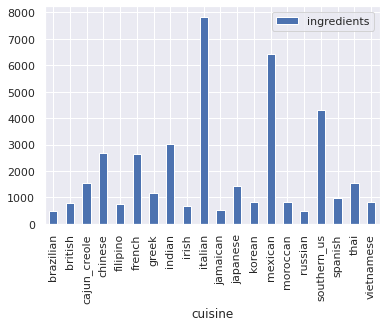

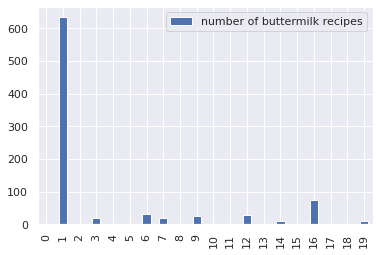

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
              ingredients
cuisine                  
brazilian             467
russian               489
jamaican              526
irish                 667
filipino              755
british               804
moroccan              821
vietnamese            825
korean                830
spanish               989
greek                1175
japanese             1423
thai                 1539
cajun_creole         1546
french               2646
chinese              2673
indian               3003
southern_us          4320
mexican              6438
italian         

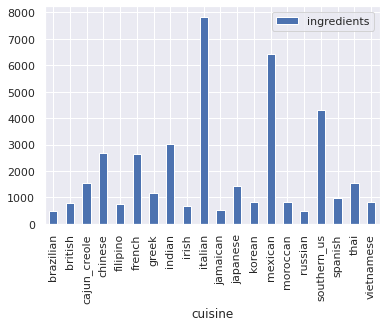

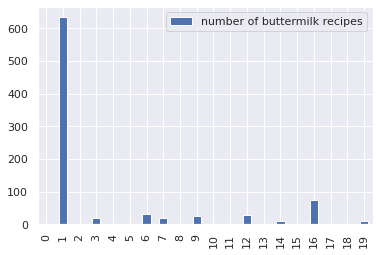

In [0]:
input_dir = '../Downloads/whats-cooking'


cuisine_data = pd.read_json('./sample_data/train 4.json')
print(cuisine_data.head(5))
cuisines = cuisine_data['cuisine'].to_numpy()

#FIND THE MOST COMMON CUISINE 
#Italian has the highest number of entries
count = cuisine_data.groupby(['cuisine']).count()
count = count.drop(['id'], axis=1)
print(count.sort_values(['ingredients']))
count.plot.bar()
#############################################################################################################

#FIND THE NUMBER OF TIMES BUTTERMILK APPEARS IN EACH TYPE OF CUISINE 

#create an array for the number of times an ingredient appears -- buttermilk appears a lot in southern
ingredientCount = {}
#pd.set_option('display.max_colwidth', -1)
cuisinesouthern_df = cuisine_data[cuisine_data['cuisine'] == "southern_us"]
#print(cuisinesouthern_df.head(35))
#look for the number of times buttermilk appears
ing = "buttermilk"
for i, row in cuisine_data.iterrows():
  ingredientCount[row['cuisine']] = 0
for i, row in cuisine_data.iterrows():
  if 'buttermilk' in row['ingredients']:
    ingredientCount[row['cuisine']] += 1

result = pd.DataFrame(ingredientCount.items(), columns=['cuisine', 'number of buttermilk recipes'])
print(result)
#############################################################################################################

result.plot.bar()

print(cuisine_data["ingredients"].count)

**Hashing**

We used a dictionary for the cuisines so that we can uniquely identify them using id numbers between 0 and 19.

We used another dictionary to get the most occuring ingredients in every single cuisine.

In [0]:
list_of_cuisines = ["greek", "southern_us", "filipino", "indian", "jamaican", "spanish", "italian", "mexican", "chinese", "british", "thai", "vietnamese", "cajun_creole", "brazilian", "french", "japanese", "irish", "korean", "moroccan", "russian"]

cuisine_labels = {}

for i in range(len(list_of_cuisines)):
  cuisine_labels[list_of_cuisines[i]] = i

for cuisine in list_of_cuisines:
  lst = []


  for i, row in cuisine_data.iterrows():
    if row['cuisine'] == cuisine:
      for ingredient in row['ingredients']:
        lst.append(ingredient)
  count = Counter(lst)
  print(f"{cuisine}:" ,count.most_common(10))  
  fig = pd.DataFrame()

count


result = pd.DataFrame(ingredientCount.items(), columns=['cuisine', 'number of buttermilk recipes'])
print(result)
#############################################################################################################



greek: [('salt', 572), ('olive oil', 504), ('dried oregano', 267), ('garlic cloves', 254), ('feta cheese crumbles', 252), ('extra-virgin olive oil', 229), ('fresh lemon juice', 222), ('ground black pepper', 221), ('garlic', 216), ('pepper', 203)]
southern_us: [('salt', 2290), ('butter', 1255), ('all-purpose flour', 1222), ('sugar', 1054), ('large eggs', 746), ('baking powder', 729), ('water', 686), ('unsalted butter', 655), ('milk', 645), ('buttermilk', 634)]
filipino: [('salt', 421), ('garlic', 325), ('water', 310), ('onions', 310), ('soy sauce', 251), ('pepper', 199), ('oil', 166), ('sugar', 136), ('carrots', 128), ('ground black pepper', 124)]
indian: [('salt', 1934), ('onions', 1195), ('garam masala', 862), ('water', 820), ('ground turmeric', 728), ('garlic', 726), ('cumin seed', 697), ('ground cumin', 683), ('vegetable oil', 593), ('oil', 546)]
jamaican: [('salt', 332), ('onions', 173), ('water', 153), ('garlic', 139), ('ground allspice', 128), ('pepper', 125), ('scallions', 111),

**Splitting our Training Set**
Next, we split our training data into a validation set and a training set. To do this, we calculated how many rows would be 10% of our data. We took 10% and made it our validation set, and the rest (90%) was our regular training data. 

In [0]:
(ing_train, cuisine_train) = (cuisine_data["ingredients"].head(35796), cuisine_data["cuisine"].head(35796))

(ing_valid, cuisine_valid) = (cuisine_data["ingredients"].tail(3978), cuisine_data["cuisine"].tail(3978))

print(ing_train, cuisine_train)
print(ing_valid, cuisine_valid)

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
35791    [sweet chili sauce, boneless chicken breast, e...
35792    [ground black pepper, salt, dried oregano, wat...
35793    [lacinato kale, parmigiano reggiano cheese, It...
35794    [dijon mustard, salt, pepper, extra-virgin oli...
35795    [extra-virgin olive oil, flour for dusting, pi...
Name: ingredients, Length: 35796, dtype: object 0               greek
1         southern_us
2            filipino
3              indian
4              indian
             ...     
35791            thai
35792    cajun_creole
35793         italian
35794         british
35795         italian
Name: cuisine, Length: 35796, dtype: object
35796    [ground 

### **Indexing our features**
We found the number of occurrences of each ingredient so that we can rank them by frequency. From that list, we gave each ingredient a number. This number is their index. 

We also made a reverse index function so that we can go from (ingredient, index) to (index, ingredient) . 

We reserved 0 for out of vocabulary ingredients, and 1 for spots that are not full. (ex: a recipe with 18 ingredients would have 2 "1s" because our set size is 20). 


In [0]:
ingredients_occ = {}
for ingredients in cuisine_data['ingredients']:
  for ingredient in ingredients:
    if ingredient not in ingredients_occ:
      ingredients_occ[ingredient] = 1
    else:
      ingredients_occ[ingredient] += 1

  
sorted_ing = sorted(ingredients_occ.items(), key=operator.itemgetter(1))

print(sorted_ing[::-1])

print(ing_train[1])


[('salt', 18049), ('olive oil', 7972), ('onions', 7972), ('water', 7457), ('garlic', 7380), ('sugar', 6434), ('garlic cloves', 6237), ('butter', 4848), ('ground black pepper', 4785), ('all-purpose flour', 4632), ('pepper', 4438), ('vegetable oil', 4385), ('eggs', 3388), ('soy sauce', 3296), ('kosher salt', 3113), ('green onions', 3078), ('tomatoes', 3058), ('large eggs', 2948), ('carrots', 2814), ('unsalted butter', 2782), ('extra-virgin olive oil', 2747), ('ground cumin', 2747), ('black pepper', 2627), ('milk', 2263), ('chili powder', 2036), ('oil', 1970), ('red bell pepper', 1939), ('purple onion', 1896), ('scallions', 1891), ('grated parmesan cheese', 1886), ('sesame oil', 1773), ('corn starch', 1757), ('ginger', 1755), ('baking powder', 1738), ('jalapeno chilies', 1730), ('dried oregano', 1707), ('chopped cilantro fresh', 1698), ('fresh lemon juice', 1679), ('diced tomatoes', 1624), ('fresh parsley', 1604), ('minced garlic', 1583), ('chicken broth', 1554), ('sour cream', 1539), ('c

In [0]:
# In the index the words are ordered by frequency they occur.

i = 1
index = {}
for ingredient in sorted_ing[::-1]:
  index[ingredient[0]] = i + 1
  i = i + 1
print(index)

# Create a reverse index so we can lookup tokens assigned to each id.
# Because we used index_from=3 (above), setting aside ids below 3 for special
# symbols, we need to add 3 to the index values.
reverse_index = dict([(value , key) for (key, value) in index.items()])
reverse_index[0] = '#' # out-of-vocabulary (OOV)
reverse_index[1] = '<UNUSED>'
max_id = max(reverse_index.keys())

print(reverse_index)

{'salt': 2, 'olive oil': 3, 'onions': 4, 'water': 5, 'garlic': 6, 'sugar': 7, 'garlic cloves': 8, 'butter': 9, 'ground black pepper': 10, 'all-purpose flour': 11, 'pepper': 12, 'vegetable oil': 13, 'eggs': 14, 'soy sauce': 15, 'kosher salt': 16, 'green onions': 17, 'tomatoes': 18, 'large eggs': 19, 'carrots': 20, 'unsalted butter': 21, 'extra-virgin olive oil': 22, 'ground cumin': 23, 'black pepper': 24, 'milk': 25, 'chili powder': 26, 'oil': 27, 'red bell pepper': 28, 'purple onion': 29, 'scallions': 30, 'grated parmesan cheese': 31, 'sesame oil': 32, 'corn starch': 33, 'ginger': 34, 'baking powder': 35, 'jalapeno chilies': 36, 'dried oregano': 37, 'chopped cilantro fresh': 38, 'fresh lemon juice': 39, 'diced tomatoes': 40, 'fresh parsley': 41, 'minced garlic': 42, 'chicken broth': 43, 'sour cream': 44, 'cayenne pepper': 45, 'brown sugar': 46, 'fresh ginger': 47, 'cooking spray': 48, 'shallots': 49, 'garlic powder': 50, 'lime': 51, 'lemon juice': 52, 'fresh lime juice': 53, 'flour': 5

In [0]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [ingredients_occ.get(i, "#") for i in token_ids]
  return tokens
  # Connect the string tokens with a space.
 

# Show the ids corresponding tokens in the first example.
# i think we need to turn ing_train into the corresponding index values 

print("Ing_train: " , ing_train[1]) #print the indices
print("Decoded: " , decode(ing_train[1])) #print the ingredients that correspond


 


Ing_train:  ['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'green tomatoes', 'yellow corn meal', 'milk', 'vegetable oil']
Decoded:  [154, 385, 18049, 3058, 4785, 361, 3388, 108, 341, 2263, 4385]


In [0]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=1)))


# Pad and truncate to 300 tokens.
sequence = []

for i in range(len(ing_train)):
  sequence.append(np.array(decode(ing_train[i])))

ing_train_padded = pad_data(sequence, max_length=20)

# Check the padded output.
print("Training data before padding: ", ing_train[0])
print("Training data padded: ", ing_train_padded[0])


Training data before padding:  ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']
Training data padded:  [ 270  229  228 7380 4438 1896  137  148  358    1    1    1    1    1
    1    1    1    1    1    1]


**Limiting our Vocab**
Some of the ingredients in our dataset are very specific. There are quite a few that are only used in one recipe, and even more that appear in fewer than 10 recipes. We do NOT want to use those specific ingredients. It will skew our predictions and cause the model to learn incorrectly. 

In [0]:
def limit_vocab(sequences, max_id, oov_id=0):
  reduced_ing = np.copy(sequences)
  reduced_ing[reduced_ing >= max_id ] = oov_id
  return reduced_ing

ing_train_reduced = limit_vocab(ing_train_padded, max_id=8000)
print(len(ing_train_reduced))
def map_cuisine(cuisines):
  return [cuisine_labels[cuisine] for cuisine in cuisines]
print("Cuisine Mappings: " , map_cuisine(cuisines))

35796
Cuisine Mappings:  [0, 1, 2, 3, 3, 4, 5, 6, 7, 6, 6, 8, 6, 7, 6, 3, 9, 6, 10, 11, 10, 7, 1, 8, 6, 8, 12, 6, 8, 7, 6, 12, 7, 10, 6, 12, 6, 2, 1, 1, 6, 13, 7, 3, 7, 8, 14, 1, 1, 1, 15, 1, 6, 1, 6, 4, 15, 3, 6, 16, 10, 10, 3, 4, 6, 10, 17, 14, 14, 1, 5, 3, 18, 6, 6, 18, 18, 11, 15, 7, 12, 1, 14, 3, 3, 6, 6, 3, 17, 5, 6, 1, 1, 0, 7, 7, 1, 3, 6, 6, 6, 15, 6, 0, 17, 3, 7, 1, 16, 17, 8, 7, 1, 8, 18, 16, 8, 16, 7, 6, 6, 6, 4, 7, 15, 5, 8, 7, 9, 3, 10, 1, 7, 5, 14, 6, 3, 9, 5, 6, 17, 3, 7, 7, 1, 14, 12, 3, 8, 6, 6, 6, 1, 0, 15, 12, 6, 17, 7, 3, 6, 7, 17, 8, 14, 8, 5, 8, 5, 15, 7, 14, 15, 7, 6, 2, 1, 6, 6, 8, 7, 3, 17, 7, 7, 15, 0, 7, 1, 8, 9, 15, 6, 7, 16, 0, 12, 15, 6, 1, 1, 1, 6, 3, 8, 15, 7, 7, 14, 7, 7, 16, 8, 7, 0, 17, 7, 5, 6, 1, 6, 7, 14, 7, 14, 2, 7, 7, 6, 7, 1, 6, 15, 6, 7, 7, 1, 1, 6, 4, 6, 17, 1, 3, 6, 3, 7, 17, 1, 11, 17, 3, 1, 7, 7, 6, 6, 17, 10, 1, 8, 14, 0, 1, 7, 3, 1, 7, 15, 9, 15, 7, 2, 7, 7, 3, 7, 3, 0, 6, 7, 8, 12, 6, 7, 6, 6, 6, 8, 6, 10, 1, 6, 7, 2, 3, 2, 6, 6, 7, 7, 

In [0]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=8000,
                           sequence_length=20,
                           embedding_dim=20):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.compat.v1.set_random_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=20,                     # output dim (for binary classification)
      activation="softmax"         # apply the sigmoid function!
  ))

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()


### **Significance of our model**
Our model takes in a set of recipes with their respective cuisine types. If we give our model a list of ingredients, it predicts the type of cuisine that recipe belongs to. Our model accuracy refers to the percentage of time that the model correctly predicted the type of cuisine.  

Epoch 1/6
504/504 [==============================] - 3s 6ms/step - loss: 1.9294 - accuracy: 0.4515 - val_loss: 1.3695 - val_accuracy: 0.6006
Epoch 2/6
504/504 [==============================] - 3s 6ms/step - loss: 1.2177 - accuracy: 0.6371 - val_loss: 1.1686 - val_accuracy: 0.6486
Epoch 3/6
504/504 [==============================] - 3s 6ms/step - loss: 1.0447 - accuracy: 0.6856 - val_loss: 1.0946 - val_accuracy: 0.6682
Epoch 4/6
504/504 [==============================] - 3s 6ms/step - loss: 0.9489 - accuracy: 0.7137 - val_loss: 1.0651 - val_accuracy: 0.6757
Epoch 5/6
504/504 [==============================] - 3s 6ms/step - loss: 0.8825 - accuracy: 0.7326 - val_loss: 1.0512 - val_accuracy: 0.6827
Epoch 6/6
504/504 [==============================] - 3s 6ms/step - loss: 0.8301 - accuracy: 0.7479 - val_loss: 1.0505 - val_accuracy: 0.6802


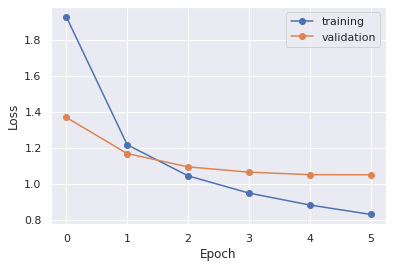

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 64)            512000    
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                25620     
Total params: 537,620
Trainable params: 537,620
Non-trainable params: 0
_________________________________________________________________
35796
35796


In [0]:
model1 = build_embeddings_model(average_over_positions=False,
                               vocab_size=8000,
                               sequence_length=20,
                               embedding_dim=64)

history = model1.fit(
  x = np.array(ing_train_reduced),  # our sparse padded training data
  y = np.array(map_cuisine(cuisine_train)),          # corresponding labels
  epochs=6,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split= .1, # use a fraction of the examples for validation
  verbose=1           # display some progress output during training
  )

history = pd.DataFrame(history.history)
plot_history(history)
model1.summary()
print(len(np.array(ing_train_reduced)))
print(len(np.array(map_cuisine(cuisine_train))))

In [0]:
predictions = model1.predict(np.array(ing_train_reduced))

true_label = np.array(map_cuisine(cuisine_train)) #labels

### **Plotting the Word Embeddings**
From Lab 5, I remembered the scatterplot of word embeddings that we made. When looking over the plot, we notice some ingredients that have slipped through the cracks. For example, there is an ingredient "fat". This seems like a strange item to be one ingredient. I believe if we went through the ingredients again, we may be able to train our data more accurately. 

In [0]:
# Display the model layers.
display(model1.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings = model1.layers[0].get_weights()[0]
display(embeddings.shape)

(8000, 64)

In [0]:
!pip install --quiet MulticoreTSNE

from MulticoreTSNE import MulticoreTSNE as TSNE
if embeddings.shape[1] > 2:
  # This cell computes the TSNE projection
  tsne = TSNE(n_components=2)

  # Retrieve the embeddings layer, which itself is wrapped in a list.
  embeddings = tsne.fit_transform(embeddings)

In [0]:


def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]
  
  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.    
plot_2d_embeddings(embeddings, id_start=500, count=500)

**Confusion Matrix**

KeyError: ignored

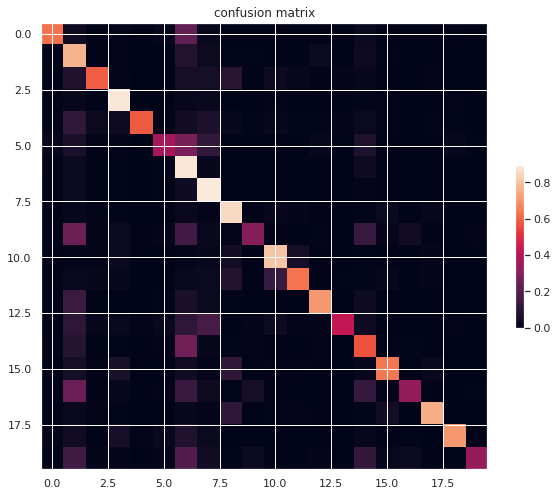

In [0]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))

cm = confusion_matrix(true_label, [np.argmax(predictions[i]) for i in range(len(predictions))])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')
plt.title("confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = cuisine_train['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [0]:

for i in range(cm_normalized.shape[0]):
  for j in range(cm_normalized.shape[1]):
    if cm_normalized[i][j] > .15:
      if i != j:

        print(list_of_cuisines[i], list_of_cuisines[j], cm_normalized[i][j])
print("----------------------")
for i in range(20):
  print(list_of_cuisines[i], cm_normalized[i][i])

  

In [0]:
cm_normalized[13]